## Week 3 - Image Recognition

### Heather Tweedie, 1/2/23

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch


2023-02-02 15:10:48.326755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 15:10:48.620462: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-02 15:10:48.705168: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-02 15:10:48.705205: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

We first load the MNIST dataset from Keras, set the image scales correctly, and define the size of the images.

In [2]:
# load data
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# re-scale inputs
train_images=train_images/255.0
test_images=test_images/255.0

# check shape of datasets
print("Shape of training images:",train_images.shape)
print("Length of training set labels:",len(train_labels))
print("First label:",train_labels[0])
print("Shape of testing images:",test_images.shape)
print("Length of testing set labels:",len(test_labels))

image_x = len(train_images[0,:,0])
image_y = len(train_images[0,0,:])


Shape of training images: (60000, 28, 28)
Length of training set labels: 60000
First label: 5
Shape of testing images: (10000, 28, 28)
Length of testing set labels: 10000


We then define a number of functions for use in training and testing the model. `addNoise` adds a random noise contribution to each pixel of an image; `trainWithNoise` trains a model on noisy images; and `accuracyWithNoise` evaluates the accuracy of a model, testing it on noisy data.

In [3]:
def addNoise(image, y_noise):
    """
    Adds a random noise contribution drawn from a uniform distribution between 0 and a user-defined maximum to an image.
    
    Args:
        image: the image to which the noise will be added
        y_noise: the maximum value for the uniform distribution from which the random noise contribution will be drawn

    Returns:
        newImage: the new image with noise added
    """
    # get image dimensions
    image_x = 28
    image_y = 28

    newImage = np.empty([image_x, image_y])
    for i in range(image_x):
        for j in range(image_y):
            newImage[i,j] = image[i,j] + np.random.uniform(0, y_noise)

    return newImage

    

def trainWithNoise(model, image_x, image_y, y_noise, batchSize, nepochs):
    """
    Trains a model on MNIST image data with noise added, and evaluates it.
    
    Args:
        model: the model to be trained
        image_x: the x length of the image
        image_y: the y length of the image
        y_noise: the maximum value for the uniform distribution from which the random noise contribution will be drawn
        batchSize: the number of samples to be drawn during each step of the training
        nepochs: the number of epochs of training to be carried out
    
    Returns:
        test_loss: the cost function after training
        test_acc: the accuracy of the model based on testing on a test set of images
    """

    imagesWithNoise = np.empty([60000, image_x, image_y])
    for i in range(len(imagesWithNoise[:,0,0])):
        imagesWithNoise[i,:,:] = addNoise(train_images[i,:,:], y_noise)

    history = model.fit(imagesWithNoise, train_labels, batch_size = batchSize, epochs = nepochs)

    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
    return test_loss, test_acc



def accuracyWithNoise(model, image_x, image_y, y_noise):
    """
    Evaluates a model trained on MNIST data on a test dataset with noise added.
    
    Args:
        model: the model to be evaluated
        image_x: the x length of the image
        image_y: the y length of the image
        y_noise: the maximum value for the uniform distribution from which the random noise contribution will be drawn
    
    Returns:
        test_loss: the cost of the model
        test_acc: the accuracy of the model
    """

    imagesWithNoise = np.empty([10000, image_x, image_y])
    for i in range(len(imagesWithNoise[:,0,0])):
        imagesWithNoise[i,:,:] = addNoise(test_images[i,:,:], y_noise)

    test_loss, test_acc = model.evaluate(imagesWithNoise, test_labels, verbose=2)
    return test_loss, test_acc

We now define and compile the network on which we will train the data:

In [4]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(15)
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
              metrics=['accuracy'])

2023-02-02 15:10:52.105647: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-02 15:10:52.106621: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-02 15:10:52.106655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2023-02-02 15:10:52.109005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train the model on the MNIST dataset. Initially, using the parameters provided in the course material (layers: [128, 10]; batch size = 100, epochs = 30), the model achieved an accuracy of around 0.94, which is lower than the acceptable level of 0.95. I tried increasing the batch size to 120 and then 140, but this only achieved an inconsistent 0.945 - 0.95. By increasing the size of the final layer in the network from 10 to 15, the accuracy of the model grew substantially, achieving an accuracy of 0.9998 - 1 on the trianing dataset. In order to make the model training faster, I reduced the number of epochs from 30 to 10, as at this point the model was already achieving high accuracies, and reduced the batch size back down to 100. This also reduced the likelihood of overfitting.

In [5]:
history = model.fit(train_images, train_labels, batch_size=100, epochs=10)

Epoch 1/10
600/600 [==============================] - 1s 2ms/step - loss: 0.3948 - accuracy: 0.8837
Epoch 2/10
600/600 [==============================] - 1s 2ms/step - loss: 0.1469 - accuracy: 0.9542
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.1113 - accuracy: 0.9658
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0942 - accuracy: 0.9707
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0800 - accuracy: 0.9754
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0716 - accuracy: 0.9779
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0626 - accuracy: 0.9803
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0565 - accuracy: 0.9818
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0518 - accuracy: 0.9837
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0449 - accuracy: 0.9853

Evaluate accuracy of model for different noise levels:

y_noise = 0.0:
313/313 - 0s - loss: 0.1081 - accuracy: 0.9716 - 429ms/epoch - 1ms/step
y_noise = 0.10526315789473684:
313/313 - 0s - loss: 0.1228 - accuracy: 0.9660 - 265ms/epoch - 846us/step
y_noise = 0.21052631578947367:
313/313 - 0s - loss: 0.2388 - accuracy: 0.9282 - 306ms/epoch - 977us/step
y_noise = 0.3157894736842105:
313/313 - 0s - loss: 0.5957 - accuracy: 0.8248 - 269ms/epoch - 860us/step
y_noise = 0.42105263157894735:
313/313 - 0s - loss: 1.2037 - accuracy: 0.6944 - 376ms/epoch - 1ms/step
y_noise = 0.5263157894736842:
313/313 - 0s - loss: 1.9453 - accuracy: 0.5825 - 394ms/epoch - 1ms/step
y_noise = 0.631578947368421:
313/313 - 0s - loss: 2.7721 - accuracy: 0.4952 - 368ms/epoch - 1ms/step
y_noise = 0.7368421052631579:
313/313 - 0s - loss: 3.5357 - accuracy: 0.4321 - 380ms/epoch - 1ms/step
y_noise = 0.8421052631578947:
313/313 - 0s - loss: 4.2715 - accuracy: 0.3653 - 363ms/epoch - 1ms/step
y_noise = 0.9473684210526315:
313/313 - 0s - loss: 4.9812 - accuracy: 0.3202 - 336ms/epoc

Text(0.5, 1.0, 'Model accuracy when evaluated against noisy data')

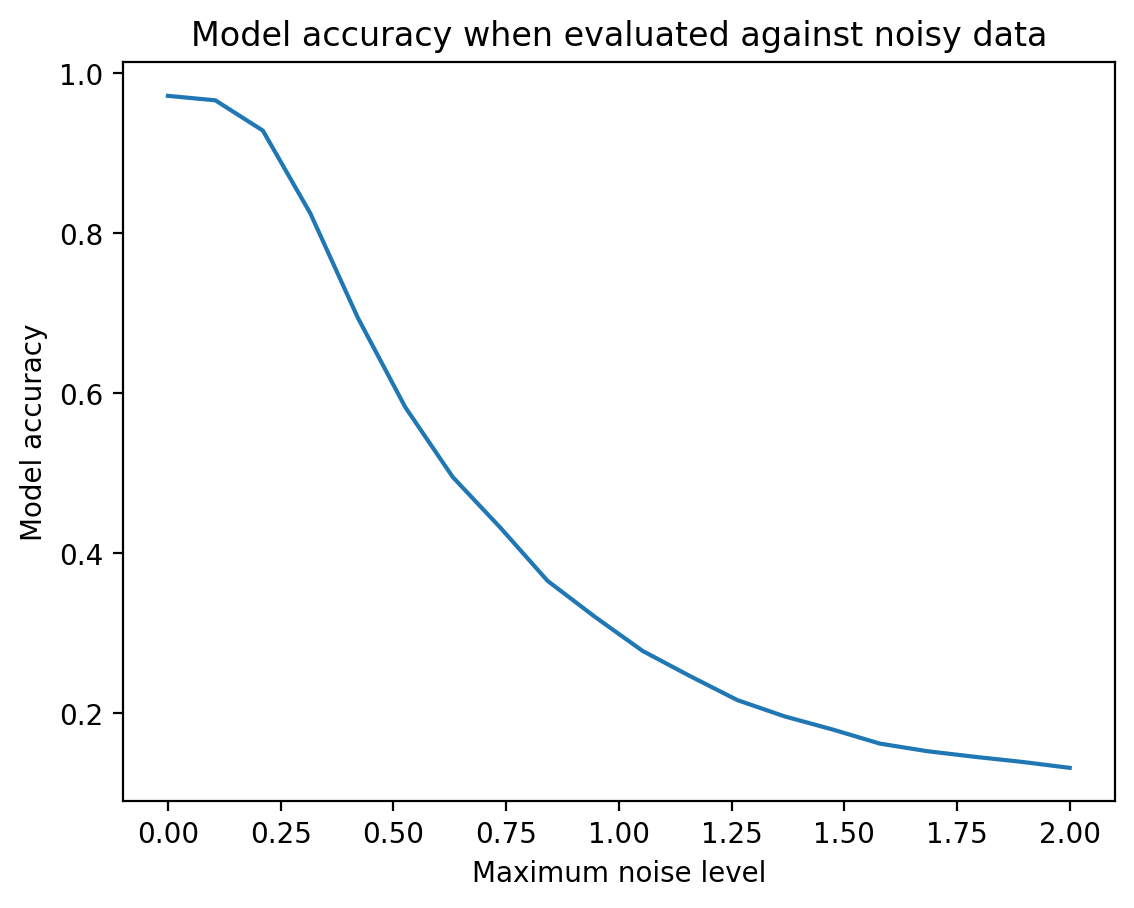

In [6]:
# test model accuracy against noisy data
noises = np.linspace(0, 2, 11)
accuracies = np.empty([len(noises)])

for i in range(len(noises)):
    print(f"y_noise = {noises[i]}:")
    test_loss, test_acc = accuracyWithNoise(model, image_x, image_y, noises[i])
    accuracies[i] = test_acc

fig, ax = plt.subplots()
ax.plot(noises, accuracies)
ax.set_xlabel('Maximum noise level')
ax.set_ylabel('Model accuracy')
ax.set_title('Model accuracy when evaluated against noisy data')

Define new model to be trained on noisy data. The final layer density is higher than previously to account for the increased difficulty the network will encounter during training.

In [7]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(20)
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
              metrics=['accuracy'])

Train model on noisy data. With increasing noise, the accuracy drops substantially. At 0.1, the accuracy with 0 noise is mostly maintained, however by 0.2 the accuracy drops to 0.1 be the end of the training. At earlier epochs however, the accuracy is ~0.7, but this drops rapidly with further training.

Epoch 1/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0855 - accuracy: 0.9739
Epoch 2/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0795 - accuracy: 0.9746
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0783 - accuracy: 0.9752
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0733 - accuracy: 0.9776
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0730 - accuracy: 0.9771
Epoch 6/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0684 - accuracy: 0.9783
Epoch 7/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0656 - accuracy: 0.9797
Epoch 8/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0646 - accuracy: 0.9791
Epoch 9/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0631 - accuracy: 0.9801
Epoch 10/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0624 - accuracy: 0.9806

Text(0.5, 1.0, 'Model accuracy when evaluated against noisy data')

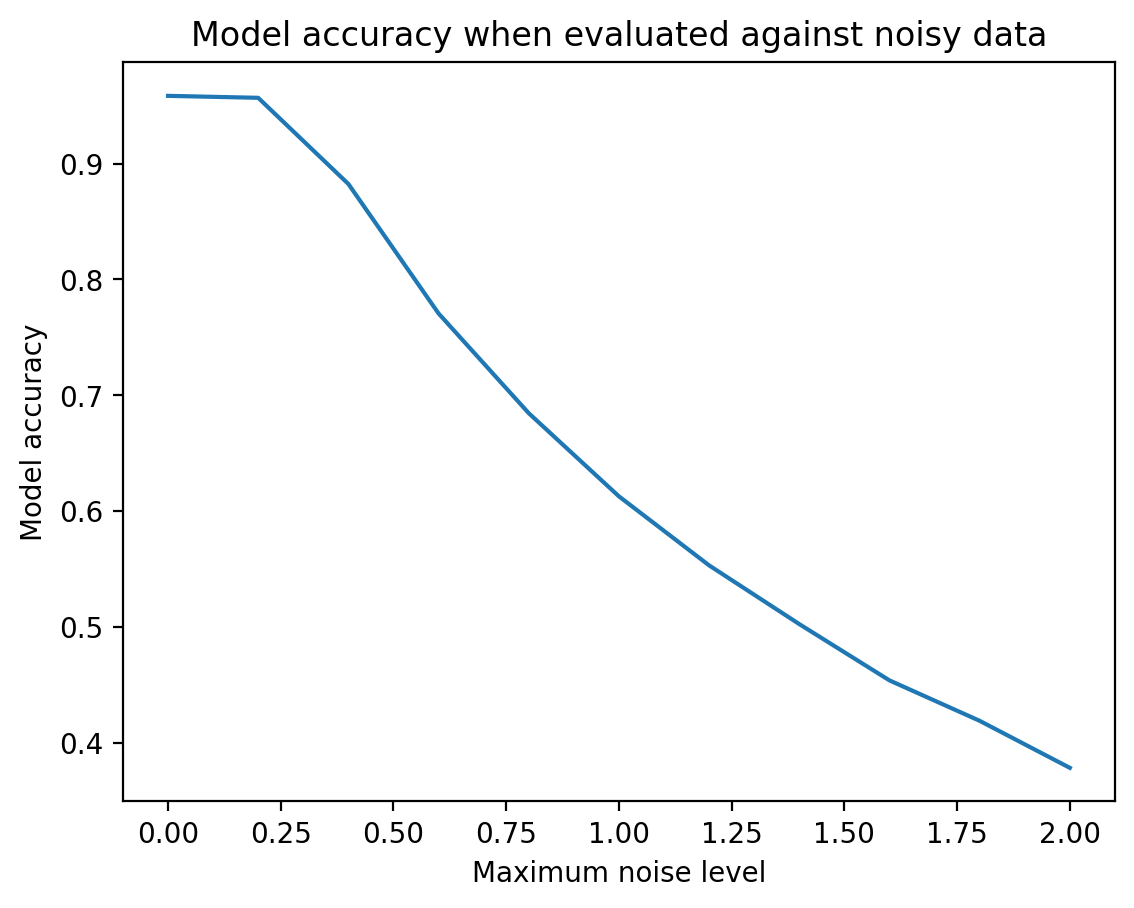

In [9]:
# train model with noisy data
acc_1 = trainWithNoise(model, image_x, image_y, 0.1, 100, 20)
print(acc_1)

# test model accuracy against noisy data
noises = np.linspace(0, 2, 11)
accuracies = np.empty([len(noises)])

for i in range(len(noises)):
    print(f"y_noise = {noises[i]}:")
    test_loss, test_acc = accuracyWithNoise(model, image_x, image_y, noises[i])
    accuracies[i] = test_acc

fig, ax = plt.subplots()
ax.plot(noises, accuracies)
ax.set_xlabel('Maximum noise level')
ax.set_ylabel('Model accuracy')
ax.set_title('Model accuracy when evaluated against noisy data')


When tested against the noisy data, the model trained on noisy data performs much better than the model trained on clean data. Although when tested on clean data they perform similarly, at greater noise levels in the test data, the accuracy of the model trained on noisy data drops much lower than that of the model trained on clean data. The model is more able to accomodate noise and 'mess' in the data, and is in some sense more adaptable.

To test the optimum noise value on which to train the model, I trained and tested the model on multiple values. This took about half an hour to run, so the code is included below as well as the final output graph to prevent the need to run it.

In [ ]:
'''
training_noises = np.linspace(0, 0.5, 6)
num_noises = 11
all_accuracies = np.empty([len(training_noises), num_noises])

for j in range(len(training_noises)):

    # train model with noisy data
    acc, loss = trainWithNoise(model, image_x, image_y, training_noises[j], 100, 20)

    # test model accuracy against noisy data
    noises = np.linspace(0, 2, num_noises)
    for i in range(len(noises)):
        print(f"y_noise = {noises[i]}:")
        test_loss, test_acc = accuracyWithNoise(model, image_x, image_y, noises[i])
        all_accuracies[j,i] = test_acc

with open('accuracy.txt', 'w') as f:
    f.write(str(all_accuracies))
'''

In [ ]:
'''
# plot testing accuracy for different models trained on noisy data
fig, ax = plt.subplots()
for i in range(len(all_accuracies[:,0])):
    ax.plot(all_accuracies[i])
ax.legend(['0.0', '0.1', '0.2', '0.3', '0.4', '0.5'])
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of models trained on different noise values, tested against noisy data')
'''


The graph output is shown below. The optimum y_noise value for training the model is 0.4, as this performs the best over a wide range of noisy test data. At 0.5 however the accuracy drops substantially, so the model should not be trained on data with noise higher than 0.4.

![image](noisy_model_accuracy.png)

It is important for a model to be able to work accurately on noisy data, as in more realistic scenarios, data are usually messy. A model needs to be able to account for this.